In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import zipfile
import matplotlib.pyplot as plt

## Loading Data

In [9]:
raw_path = 'Data-20250729T201332Z-1-001.zip'

In [10]:
!unzip {raw_path} -d zipped_data

Archive:  Data-20250729T201332Z-1-001.zip
  inflating: zipped_data/Data/How to use data.docx  
  inflating: zipped_data/Data/CRWV.zip  
  inflating: zipped_data/Data/FROG.zip  
  inflating: zipped_data/Data/SOUN.zip  


In [15]:
input_zip_dir = 'zipped_data/Data'
output_extract_dir = 'data'

for path in glob(os.path.join(input_zip_dir, '*.zip')):
    ticker_name = os.path.splitext(os.path.basename(path))[0]
    target_path = os.path.join(output_extract_dir, ticker_name)

    os.makedirs(target_path, exist_ok=True)

    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(target_path)

    print(f"Extracted {path} → {target_path}")


Extracted zipped_data/Data/FROG.zip → data/FROG
Extracted zipped_data/Data/CRWV.zip → data/CRWV
Extracted zipped_data/Data/SOUN.zip → data/SOUN


## Preprocessing

In [3]:
path = 'data/'
dfs = []
for ticker in os.listdir(path):
    ticker_path = os.path.join(path, ticker)
    if os.path.isdir(ticker_path):
        for file in os.listdir(ticker_path):
            if file.endswith('.csv'):
                file_path = os.path.join(ticker_path, file)
                df = pd.read_csv(file_path)

                dfs.append(df)
                
df = pd.concat(dfs, ignore_index=True)
df['ts_event'] = df['ts_event'].apply(lambda x: x + '.0' if '.' not in x else x)
df['ts_event'] = pd.to_datetime(df['ts_event'], errors='coerce', utc=True)
df['date'] = df['ts_event'].dt.date
df['minute'] = df['ts_event'].dt.floor('T').dt.time
df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
print(f'df shape: {df.shape}')
df.head()

/var/folders/_z/yy80d_qn4f1c3qqdk__xx2dc0000gn/T/ipykernel_34713/3806231453.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T').dt.time


df shape: (7976634, 76)


,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,date,minute
0,2025-04-21 13:30:00.240997412+00:00,2025-04-21 13:30:00.240997412+00:00,10,2,20613,A,A,6,39.70,100,...,1,38.10,39.85,53,90,4,1,CRWV,2025-04-21,13:30:00
1,2025-04-21 13:30:00.308769049+00:00,2025-04-21 13:30:00.308769049+00:00,10,2,20613,T,N,0,38.62,39767,...,1,38.10,39.85,53,90,4,1,CRWV,2025-04-21,13:30:00
2,2025-04-21 13:30:00.308769049+00:00,2025-04-21 13:30:00.308769049+00:00,10,2,20613,A,N,0,38.50,100,...,5,38.24,39.17,2,55,1,1,CRWV,2025-04-21,13:30:00
3,2025-04-21 13:30:00.308769049+00:00,2025-04-21 13:30:00.308769049+00:00,10,2,20613,A,B,4,38.35,500,...,5,38.36,39.17,15,55,1,1,CRWV,2025-04-21,13:30:00
4,2025-04-21 13:30:00.317034246+00:00,2025-04-21 13:30:00.317034246+00:00,10,2,20613,A,B,9,38.36,100,...,5,38.36,39.17,115,55,2,1,CRWV,2025-04-21,13:30:00


## Exploration

In [23]:
def simulate_slippage(row, sizes):
    prices = [row[f'ask_px_{i:02d}'] for i in range(10)]
    volumes = [row[f'ask_sz_{i:02d}'] for i in range(10)]
    mid_price = (row['bid_px_00'] + row['ask_px_00']) / 2

    impacts = []
    for x in sizes:
        remaining = x
        cost = 0
        for p, s in zip(prices, volumes):
            fill = min(remaining, s)
            cost += fill * p
            remaining -= fill
            if remaining <= 0:
                break
        if remaining > 0:
            impacts.append(np.nan)
        else:
            avg_price = cost / x
            impacts.append(avg_price - mid_price)
    return np.array(impacts)

In [32]:
symbols = df['symbol'].unique()
trade_sizes = np.arange(10, 1000, 40)
median_prices = df.groupby('symbol')['mid_price'].median()

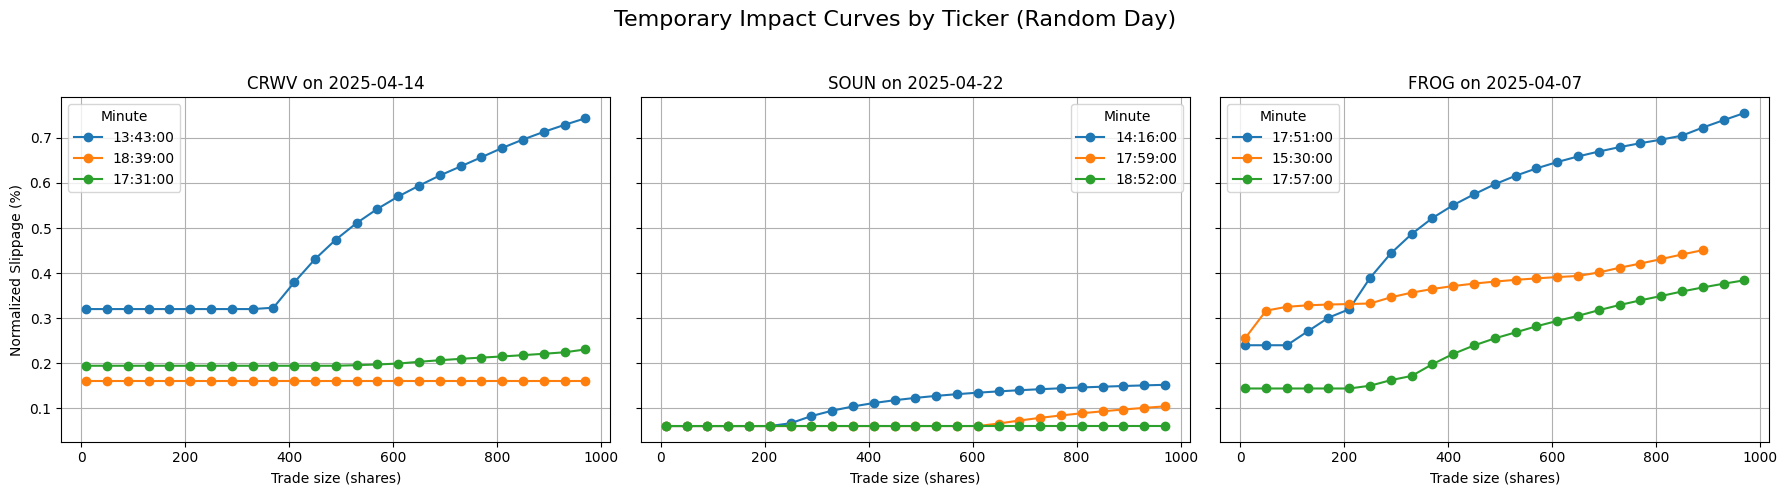

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, symbol in enumerate(symbols):
    ax = axes[idx]
    dates = df[df['symbol'] == symbol]['date'].unique()
    random_date = np.random.choice(dates)
    q = df[(df['symbol'] == symbol) & (df['date'] == random_date)]
    minutes = q['minute'].unique()
    random_minutes = np.random.choice(minutes, 3, replace=False)

    symbol_median_price = median_prices[f'{symbol}']

    for minute in random_minutes:
        row = q[q['minute'] == minute].iloc[0]
        slippage = simulate_slippage(row, trade_sizes)
        normalized_slippage = 100 * (slippage / symbol_median_price)
        ax.plot(trade_sizes, normalized_slippage, marker='o', label=f"{minute}")

    ax.set_title(f"{symbol} on {random_date}")
    ax.set_xlabel("Trade size (shares)")
    ax.grid(True)
    ax.legend(title="Minute")
    if idx == 0:
        ax.set_ylabel("Normalized Slippage (%)")

plt.suptitle("Temporary Impact Curves by Ticker (Random Day)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
